# Getting data: Holiday homes in R&oslash;rvig, Denmark sold since 1992

## Load libraries

In [1]:
import requests
import time
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import json
import boliga
from rorvig import include_map
#import geopandas as gpd
#from mpl_toolkits.basemap import Basemap
#import leafmap

## Where we get data and what we get
The Danish website [boliga.dk](https://www.boliga.dk) has data on property sales and listings in Denmark, and offers various analytics services for individuals buying or selling a property. In 2007 a law was passed making all sales prices since 1992 public, so boliga.dk has information on:
* All sales since 1992
* All listings since 2007
* A copy of BBR data (public registry of buildings and lots) on all properties

I'll also need a map of the area to visualize the locations. I'll get back to that later.

How do get and combine the data from boliga.dk?
### List of all properties
By calling api.boliga.dk/api/v2/sold/search/results we can get a list of all properties. We only want holiday homes (`propertyType` 4) in R&oslash;rvig (`zipcode` 4581), so we restrict to that.

Let's look at what we get. The response is a dictionary with keys `meta` and `results` (list of properties).

In [2]:
list_url = "https://api.boliga.dk/api/v2/sold/search/results"
parameters = {'sort': 'date-d', 
              'zipcodeFrom': 4581, 
              'zipcodeTo': 4581,
              'street': '',
              'propertyType': 4,
              'page': 1}
response = requests.get(list_url, params = parameters)
response.json()['meta']

{'pageIndex': 1,
 'pageSize': 50,
 'totalCount': 1739,
 'totalPages': 35,
 'minPage': 1,
 'maxPage': 6,
 'countFrom': 1,
 'countTo': 50}

The reponse contains at most 50 properties per page, so we'll use the parameter `page` in the request to get all the properties. The `meta` part of the response contains total page count and lets us know how many pages to run through. I've build this into the function `pull_listings` in `boliga.py`. Here's an example of a property on the list. We'll save it to use an example below.

In [3]:
example = response.json()['results'][0]
example

{'estateId': 1793640,
 'address': 'Søndergårdsvænget 12',
 'zipCode': 4581,
 'price': 2906000,
 'soldDate': '2021-07-28T22:00:00.000Z',
 'propertyType': 4,
 'saleType': 'Alm. Salg',
 'sqmPrice': 49254.24,
 'rooms': 3.0,
 'size': 59,
 'buildYear': 1962,
 'change': 7.82931376,
 'guid': '38755BE9-693C-4855-9A39-DFD7A6B2FBBE',
 'latitude': 55.95068,
 'longitude': 11.748748,
 'municipalityCode': 306,
 'estateCode': 18087,
 'city': 'Rørvig',
 'groupKey': None,
 'canGetVR': True}

For each property in the list, the dictionary includes:
* Information on property: `address`, `longitude`, `lattitude`, `size`, `buildYear`, `rooms`
* Ids for property: `guid`, `municipalityId` (always 306 in our case), `estateCode`, and `estateId` (but 0 for some)
* Information on the *last* sale, if any: `saleType` (mainly Regular ("Alm. Salg") and Within family ("Fam. Salg")), `soldDate`, `price`, `change` (sold price compared to listed price, 0.0 if no listed price)

The dictionary lacks:
* Previous sales and listings (dates and price)
* Size of lot and year of last renovation
* If there are extra buildings (I'm mainly thinking about smaller guest houses)
* Things I personally care about like roof type and outer wall materials.

#### Quickly comparing with other zipcodes or all of Denmark
The `totalCount` in the `meta` part of the reponse allows us to quickly (i.e., with few API requests) get some numbers that allow us to compare with other zipcodes or all of Denmark. This is done by varying the following request parameters:
* `bbrsearch: 1` for including the properties that haven't been sold
* `saleType` set to 1 for regular sales ('Alm. Salg') or 2 for sales within the family ('Fam. Salg')
* `zipcodeFrom` and `zipcodeTo` which can be set to `None`

I've build this into the function `get_totalcount` in `boliga.py`.

### Previous sales and listings
#### Option 1: Event history
By calling api.boliga.dk/api/v2/estate/{estateId}/history with the `estateId` of a property, one can get a list of  events, each categorized as "announced", "pulled", or "sold", and with date and price. This is very useful for looking at how long properties are listed, but lots of properties don't have an estateId even though they have been listed and sold previously, and I haven't spotted the pattern in those missing an estateId.
#### Option 2: Sold info
By calling api.boliga.dk/api/v2/sold/info/{municipalityCode}/{estateCode}/{guid} with the `guid`, `municipalityCode`, and `estateCode` of a property, one can get a dict that includes all sales (with sold date, price, sale type) and listings (with date last seen, price). This is less useful than the event history, but all of the holiday homes in R&oslash;rvig that have changed owner at least once (since 1992) have this info (except one, for mysterious reasons).

I've build this into the functions `get_soldinfo` and `update_soldinfo` in `boliga.py` which take in a list of properties. They return a dictionary with the guids as keys.

Let's look at an example of what we get. We'll use the holiday home we saved as `example`.

In [4]:
soldinfo_url = "https://api.boliga.dk/api/v2/sold/info/{municipalityCode}/{estateCode}/{guid}".format(
    municipalityCode = example['municipalityCode'],
    estateCode = example['estateCode'],
    guid = example['guid'])
response = requests.get(soldinfo_url)
response.json()

{'canGetVR': True,
 'userHasEvalReport': False,
 'isActive': False,
 'currentEstateId': None,
 'address': 'Søndergårdsvænget 12',
 'addressObj': {'street': 'Søndergårdsvænget',
  'number': '12',
  'zipCode': 4581},
 'zipCode': 4581,
 'city': 'Rørvig',
 'coordinates': {'latitude': 55.95068, 'longitude': 11.748748},
 'guid': '38755be9-693c-4855-9a39-dfd7a6b2fbbe',
 'propertyType': 4,
 'sales': [{'date': '2021-07-29T00:00:00',
   'price': 2906000,
   'saleType': 'Alm. frit salg'}],
 'previousListings': [{'id': 1793640,
   'address': 'Søndergårdsvænget 12',
   'lastSeen': '2021-06-15T02:18:18',
   'price': 2695000,
   'zipCode': 4581,
   'city': 'Rørvig'}]}

Notice that here, regular sales are called 'Alm. frit salg' instead of 'Alm. Salg', and sales within the family are called 'Familieoverdragelse' instead of 'Fam. Salg'. (One could also notice that even though holiday home prices have increased dramatically in 2020 and 2021, the price of the regular sale in 2005 is much higher than the price of the family sale in 2021.)

### BBR data
By calling api.boliga.dk/api/v2/bbrinfo/bbr with the `guid` of a property as parameter, one gets a copy of all BBR data on the property. This includes lot size, number of buildings and their type, year of last rebuilding, and of course roof type and outer wall materials. One has to watch out for errors in the BBR data, though. 

Despite the name, there's more than just the BBR data: The duration of all listings are included, something that sold info mentioned above lacks.

I've build this into the function `get_bbrinfo` in `boliga.py` in a way where name and address of owner is immediately popped and therefore not kept. It returns a dictionary with the guids as keys.

Let's look at an example of what we get. We'll use the holiday home we saved as `example`.

In [5]:
guid = example['guid']
bbrinfo_url = "https://api.boliga.dk/api/v2/bbrinfo/bbr"
response = requests.get(bbrinfo_url, params = {'id': guid})
result = response.json()
result.pop('esrOwnershipInfo')
result

{'unitId': '38755be9-693c-4855-9a39-dfd7a6b2fbbe',
 'isSalesValid': False,
 'isActive': False,
 'addressString': 'Søndergårdsvænget 12',
 'gadeString': 'Søndergårdsvænget',
 'hus_nr': '12',
 'etagebetegn': '',
 'side_Doernr': '',
 'zipString': '4581 Rørvig',
 'zipCodeString': '4581',
 'imageUrl': 'https://i.boliga.org/dk/550x/1793/1793640.jpg',
 'isApartment': False,
 'propertyType': 4,
 'municipalityCode': 306,
 'esrCode': 18087,
 'lat': 55.9506793839583,
 'lon': 11.7487474481344,
 'isBlocked': False,
 'isInSalesAgent': False,
 'isInWatchlist': False,
 'isCoop': False,
 'addressFloor': None,
 'watchlistNote': None,
 'ejendomsværdiskat': 4900.0,
 'grundskyld': 12573.2,
 'canGetVR': True,
 'propertyTypeName': 'Fritidshus',
 'bbrInfoBox': {'monthlyPropertyTax': 1456.0,
  'lotSize': 2760,
  'roomsQuantity': 3,
  'area': 59,
  'areaRecorded': 0,
  'evaluationPrice': 960000,
  'basementSize': 0},
 'relatedImages': None,
 'buildingInfo': {'buildingNumber': 1,
  'buildingUsage': 'Sommerhus',


My notes on the data we get:
* What is `agentInfo`? Let's so if we can find out by comparing with a property that was sold after I started recording daily listings!
* `bbrInfoBox` includes: `lotSize`, `area` (size of building), `evaluationPrice`, `basementSize`
* `buildingInfo` includes: `constructionYear`, `latesstRebuildYear` (sic!), `buildingArea`, `businessArea`, `livingArea`, `heatingSupplyCode`, `outerWalls`, `roof`, `heatingCode`
* `unitInfo` includes: `toiletQuantity`, `bathroomQuantity`, `kitchenCode`
* `additionalBuldingInfos` (sic!) is a list similar to `buildingInfo`, includes: `buildingUsage`
* You need to drop `esrOwnershipInfo` since it contains the name and address of the owner.

It turns out that there are various issues/errors with the BBR data. We'll get back to that.

## Load data
### List of all properties (`bbrsearch`)
#### Option 1: Only run this cell if you've never run it (with `write = True` to write to `bbrsearch.txt`)
It takes a minute or so to get all properties from api.boliga.dk (because of `time.sleep(1)` between each API request to not annoy them at boliga.dk), so you usually want to avoid running it.

In [6]:
#bbrsearch = boliga.pull_listings(category = 'bbrsearch', write = True, date = False, silent=True)

#### Option 2: Read from `bbrsearch.txt`

In [7]:
with open('bbrsearch.txt', 'r') as file:
    bbrsearch = json.load(file)

### Previous sales and listings (`soldinfo` based on `bbrsearch`)
#### Option 1: Only run this cell if you've never run it (with `write = True` to write to `soldinfo.txt`)
It takes 30-35 minutes due to the `time.sleep(1)` between each API request. Expect 1 error.

In [8]:
# soldinfo, errors = boliga.get_soldinfo(bbrsearch, write=True)\
# print("Number of errors: {}\n{}".format(len(errors),errors))

#### Option 2: Read from `soldinfo.txt`

In [9]:
with open('soldinfo.txt', 'r') as file:
    soldinfo = json.load(file)

#### Option 3: If it's been a while since you last updated `soldinfo.txt`
This pulls all properties sold since 2021, pulls their sold info, reads `soldinfo.txt` and updates it, and returns the complete updated sold info.

In [10]:
#soldinfo, errors = boliga.update_soldinfo(write=True)
#print("Number of errors: {}\n{}".format(len(errors),errors))

### BBR data (`bbrinfo` based on `bbrsearch`)
#### Option 1: Only run this cell if you've never run it (with `write = True` to write to `bbrinfo.txt`)
It takes 40-45 minutes due to the `time.sleep(1)` between each API request.

In [11]:
# bbrinfo, bbrerrors = boliga.get_bbrinfo(bbrsearch, write=True)\
# print("Number of errors: {}\n{}".format(len(bbrerrors),bbrerrors))

#### Option 2: Read from `bbrinfo.txt`

In [12]:
with open('bbrinfo.txt', 'r') as file:
    bbrinfo = json.load(file)

#### Option 3: Update `bbrinfo.txt` (might be necessary if you've updated `bbrsearch`)
If your update of `bbrsearch` has resulted in even more duplicates of never-sold holiday homes, then you'll need to run the following to get the BBR data on your new duplicates. You may also run in to other issues.

In [13]:
# bbrinfo, bbrerrors = boliga.update_bbrinfo(bbrsearch, write=True)\
# print("Number of errors: {}\n{}".format(len(bbrerrors),bbrerrors))

## Looking a properties (`bbrsearch` only)

In [14]:
data = pd.DataFrame(bbrsearch)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   estateId          2327 non-null   int64  
 1   address           2327 non-null   object 
 2   zipCode           2327 non-null   int64  
 3   price             2327 non-null   int64  
 4   soldDate          2327 non-null   object 
 5   propertyType      2327 non-null   int64  
 6   saleType          2327 non-null   object 
 7   sqmPrice          1732 non-null   float64
 8   rooms             2327 non-null   float64
 9   size              2327 non-null   int64  
 10  buildYear         2327 non-null   int64  
 11  change            2327 non-null   float64
 12  guid              2327 non-null   object 
 13  latitude          2327 non-null   float64
 14  longitude         2327 non-null   float64
 15  municipalityCode  2327 non-null   int64  
 16  estateCode        2327 non-null   int64  


In [15]:
data['soldYear']=pd.to_datetime(data['soldDate'], errors='coerce').dt.year

In [16]:
descriptive_columns = ['price', 'rooms', 'size', 'buildYear', 'soldYear']
data[descriptive_columns].describe()

,price,rooms,size,buildYear,soldYear
count,2.327000e+03,2327.000000,2327.000000,2327.000000,1732.000000
mean,9.721452e+05,3.868930,81.292651,1935.873227,2009.826212
std,1.176325e+06,1.215234,34.436626,257.306146,8.458028
min,0.000000e+00,0.000000,2.000000,0.000000,1992.000000
25%,0.000000e+00,3.000000,60.000000,1956.000000,2003.000000
50%,6.893000e+05,4.000000,76.000000,1966.000000,2012.000000
75%,1.402500e+06,4.000000,98.000000,1982.500000,2017.000000
max,1.470000e+07,10.000000,298.000000,2021.000000,2021.000000


#### Include a map
We have longitude and latitude in our data, so I've tried to figure out how to best plot the data on a map and have looked a bit at basemap, GeoPandas, and leafmap. To not get completely sidetracked, I've decided to download a map from [openstreetmap.org](https://www.openstreetmap.org/) and use that for now. 

I've downloaded one of all of R&oslash;rvig and all of the area called V&aelig;ngerne. The coordinates used for downloading the map are specified as `longmin`, `longmax`, `latmin`, and `latmax` within the function `include_map`. For the map of all of R&oslash;rvig, they are in fact `data['longitude].min()`, `data['longitude'].max()`, `data['latitude'].min()`, and `data['latitude'].max()`. The function `include_map` relies on the inputted dataframe having series `longitude` and `lattitude`. Set `Vaengerne=True` to zoom in on V&aelig;ngerne. The function `include_map` is imported from `rorvig.py`.

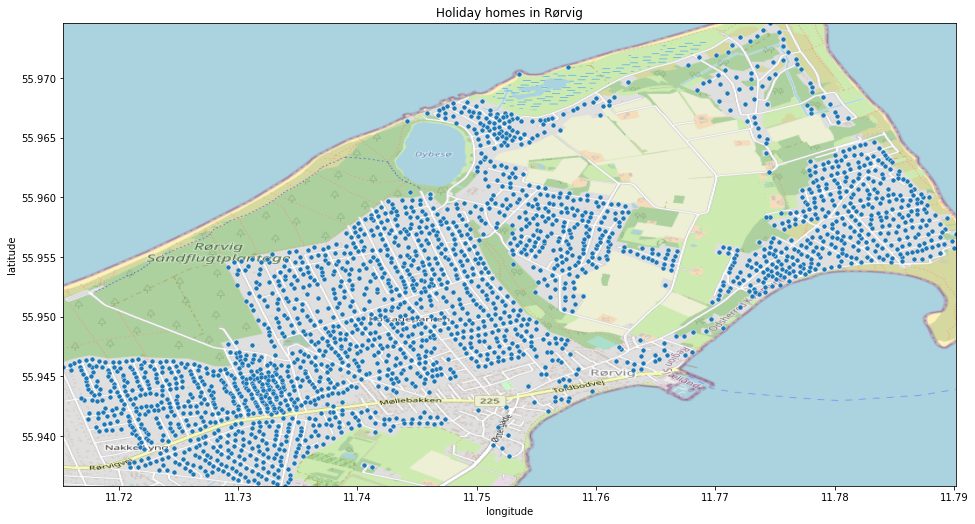

In [17]:
include_map(data, s=25)

### How many holiday homes have never changed owner (since 1992)?

In [18]:
data['neverSold'] = (data['soldYear'].isnull())

In [19]:
data['neverSold'].value_counts()

False    1732
True      595
Name: neverSold, dtype: int64

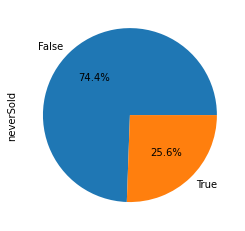

In [20]:
data['neverSold'].value_counts().plot.pie(autopct="%.1f%%");

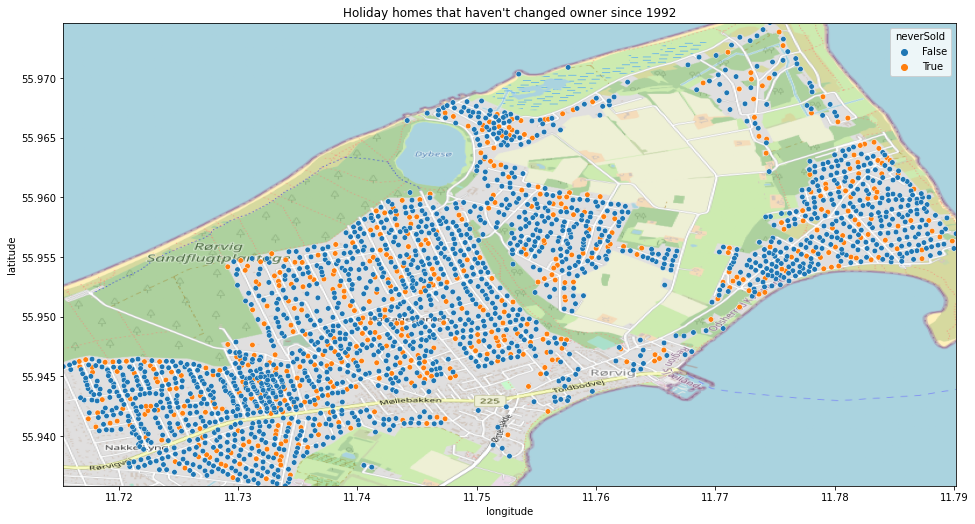

In [21]:
include_map(data, hue='neverSold', title="Holiday homes that haven't changed owner since 1992", s=30)

#### Comparing with other zipcodes and all of Denmark
Is it common with 25.6% never-sold? The short answer is yes! Let's look at that and look at the percentage of holiday homes where their last sale was regular resp. family. Ideally, we would look at the percentage of holiday homes where all sales are family sales, but that would require pulling sold info for all those where last sale is family sale (for all of Denmark, that's about 30,000).

We'll compare R&oslash;rvig (4581) with all of Denmark and with the zipcodes 4583 (Sj&aelig;llands Odde) and 4500 (Nyk&oslash;bing Sj. and surrounding villages, including Nakke and other areas close to R&oslash;rvig).

(Note that the amount of never-sold in 4581 might differ slightly from what it is above if `bbrsearch` above is read from file instead of being requested. There are always a few 'ghosts', and we'll address those further below.)

In [22]:
zipcodes = [4581, 4500, 4583, None]
for zipcode in zipcodes:
    if zipcode:
        print('Zipcode:', zipcode)
    else:
        print('Denmark')
    total = boliga.get_totalcount(zipcodeFrom = zipcode, zipcodeTo = zipcode, bbrsearch = True, propertyType = 4, saleType = None)
    sales = boliga.get_totalcount(zipcodeFrom = zipcode, zipcodeTo = zipcode, bbrsearch = False, propertyType = 4, saleType = None)
    regular = boliga.get_totalcount(zipcodeFrom = zipcode, zipcodeTo = zipcode, bbrsearch = False, propertyType = 4, saleType = 1)
    family = boliga.get_totalcount(zipcodeFrom = zipcode, zipcodeTo = zipcode, bbrsearch = False, propertyType = 4, saleType = 2)
    print('Never-sold:\t{neversold:.1%}\nRegular sales:\t{regularsales:.1%}\nFamily sales:\t{familysales:.1%}\nHoliday homes:\t{total}\n'.format(neversold=(total-sales)/total, regularsales=regular/total, familysales=family/total, total=total))

Zipcode: 4581
Never-sold:	25.3%
Regular sales:	51.4%
Family sales:	22.4%
Holiday homes:	2327

Zipcode: 4500
Never-sold:	24.5%
Regular sales:	58.0%
Family sales:	15.8%
Holiday homes:	7893

Zipcode: 4583
Never-sold:	22.8%
Regular sales:	62.4%
Family sales:	12.9%
Holiday homes:	2906

Denmark
Never-sold:	25.4%
Regular sales:	60.2%
Family sales:	12.7%
Holiday homes:	242384



This is of course based on the *last sale* and not all sales of each holiday home (and it ignores the issue with dublicates mentioned below, or rather, it assumes that it occurs evenly), but there is a clear indication of my mom being right that more holiday homes in R&oslash;rvig stay within families.

### Data issue: some never-sold holiday homes appear more than once in `bbrsearch`
I accidentally discovered this when looking at the BBR data. Some holiday homes addresses appear more than once in the list `bbrsearch`. I'll refer to the extra copies as ghosts.

#### 95 ghosts in total
There are 4 addresses appearing 3 times, and 87 addresses appearing 2 times. So luckily there aren't that many.

In [23]:
address_counts = data['address'].value_counts()
address_counts

Degnevænget 8          3
Skansehagevej 55       3
Solsortevej 23         3
Lokkemosevej 40        3
Lindegårdsvænget 18    2
                      ..
Granbovej 15           1
Forårsvej 22           1
Dybesøvej 82           1
Hesteskoen 18B         1
Birkelunden 30         1
Name: address, Length: 2232, dtype: int64

In [24]:
len(address_counts[address_counts == 3])

4

In [25]:
len(address_counts[address_counts == 2])

87

In [26]:
len(data)-len(address_counts)

95

#### All ghosts are never-sold
This means that the errors are restricted to data we won't be using for regressors.

In [27]:
data[data['neverSold']==False]['address'].value_counts()

Nattergalevej 8        1
Herman Sandby Vej 8    1
Sandgravene 4          1
Tigervej 26            1
Mågevej 15             1
                      ..
Dybesøvej 110          1
Lærkevænget 26         1
Løvevej 7              1
Æblevangen 22          1
Birkelunden 30         1
Name: address, Length: 1732, dtype: int64

#### The ghosts (and all other entries) have their own `guid`

In [28]:
data['guid'].value_counts()

CEBFC1D6-FA27-4E0A-978A-ABF4A014DC71    1
853EF2BD-AACB-4495-99A1-FAC84B72E0A3    1
4B5340FE-0562-4800-9CDE-6A640C08AD34    1
9CDCE4CB-E9F3-4DE4-B004-CDA008285E47    1
411372BC-3344-4476-8AA9-061B80FA2DF5    1
                                       ..
BFD74B5A-4F1D-4257-9177-E719478F0E03    1
61ACEC1B-53FA-473E-A474-39A07E6B01C2    1
6CD4C02E-5366-4D4A-9AD4-C60A410C3936    1
C6D415C9-CD45-4D92-9ED9-256869F1F014    1
43FADDAF-D16C-4E9C-BE8D-56DC3E1B47BB    1
Name: guid, Length: 2327, dtype: int64

#### `estateCode` is unique
Luckily, `estateCode` and address go together, i.e., if the addresses are the same, then so are the estatecodes, and vice versa. If addresses are the same, then so are the estatecodes:

In [29]:
for item in bbrsearch:
    for otheritem in bbrsearch:
        if item == otheritem:
            continue
        elif item['address'] == otheritem['address']:
            if item['estateCode'] != otheritem['estateCode']:
                print('Duplicate estatecodes at address {}'.format(item['address']))

And vice versa:

In [30]:
for item in bbrsearch:
    for otheritem in bbrsearch:
        if item == otheritem:
            continue
        elif item['estateCode'] == otheritem['estateCode']:
            if item['address'] != otheritem['address']:
                print('Duplicate address of estatecode {}'.format(item['estateCode']))

#### Source of error is in BBR data
I've looked up a few of the addresses, and it looks like the errors occur when there is more than one building on the lot (probably a guest-house or something similar).

In [31]:
ghosts = [item for item in bbrsearch if item['address'] in list(address_counts[address_counts >= 2].index)]
ghostdata = pd.DataFrame(ghosts)
essentialghostdata = ghostdata[['address', 'rooms', 'size', 'buildYear', 'latitude', 'longitude']]
essentialghostdata

,address,rooms,size,buildYear,latitude,longitude
0,Langesølodden 5,5.0,101,2004,55.964336,11.782134
1,Langesølodden 5,2.0,53,2004,55.964336,11.782134
2,Lindevangen 20,1.0,13,1969,55.938423,11.727360
3,Lindevangen 20,3.0,70,1969,55.938423,11.727360
4,Engtoften 3,1.0,12,1971,55.941013,11.734295
...,...,...,...,...,...,...
181,Kirkestien 25,4.0,81,0,55.949886,11.740449
182,Kongelundsvej 6,1.0,14,1947,55.942560,11.734724
183,Kongelundsvej 6,3.0,26,1947,55.942560,11.734724
184,Gøgevænget 8,2.0,30,2017,55.952500,11.735438


In [32]:
essentialghostdata.describe()

,rooms,size,buildYear,latitude,longitude
count,186.000000,186.000000,186.000000,186.000000,186.000000
mean,2.784946,59.005376,1704.166667,55.953349,11.750774
std,1.512824,37.878254,673.677434,0.008001,0.018854
min,0.000000,2.000000,0.000000,55.937645,11.716733
25%,2.000000,30.000000,1947.000000,55.946323,11.736344
50%,3.000000,56.500000,1960.000000,55.953665,11.747022
75%,4.000000,79.750000,1980.000000,55.958006,11.769704
max,7.000000,187.000000,2017.000000,55.972706,11.786373


#### Fixing the error in `bbrsearch`
These are all never-sold so it won't cause too much trouble that there are duplicates.
After looking at some of the addresses, I've decided to choose the entries with highest `size` but where I copy `rooms` or `buildYear` from the other entry if it is 0.0. (*The* other entry? We'll have to look closely at the addresses with 3 entries.)
We'll do this and remove the other entries from `bbrsearch` before we continue further.

Group the ghosts with the same estatecode together by making a list `ghostgroups` where each element is a list of length 2 or 3 containing elements from `ghosts` (originally from `bbrsearch`) with the same estatecode. We double-check that there are 91 elementes in `ghostsgroups` corresponding to the 4 of length 3 and the 87 of length 2.

In [33]:
ghostgroups = []
ghostscopy = ghosts.copy()
for ghost in ghosts:
    if ghost not in ghostscopy:
        continue
    estatecode = ghost['estateCode']
    group = []
    for otherghost in ghosts:
        if otherghost['estateCode'] == estatecode:
            group.append(otherghost)
            ghostscopy.remove(otherghost)
    ghostgroups.append(group)

In [34]:
len(ghosts)

186

In [35]:
len(ghostgroups)

91

Let's look at the 4 addresses with 3 entries each. I wasn't sure about Skansehagevej 55 before looking it up, but for the other 3 addresses I'm not worried about following the suggested rule. There's bound to be some `buildYear` that are too low, though, especially for Skansehagevej 55, for instance.

In [36]:
addresses = []
for group in ghostgroups:
    if len(group) == 3:
        addresses.append(group[0]['address'])

In [37]:
essentialghostdata[essentialghostdata['address'].isin(addresses)]

,address,rooms,size,buildYear,latitude,longitude
76,Degnevænget 8,2.0,58,2007,55.948586,11.740416
77,Degnevænget 8,3.0,48,1951,55.948586,11.740416
78,Degnevænget 8,2.0,68,1951,55.948586,11.740416
119,Solsortevej 23,1.0,12,2006,55.955720,11.760006
120,Solsortevej 23,3.0,73,1965,55.955720,11.760006
121,Solsortevej 23,1.0,9,2006,55.955720,11.760006
137,Skansehagevej 55,2.0,22,0,55.954235,11.780334
138,Skansehagevej 55,4.0,146,0,55.954235,11.780334
139,Skansehagevej 55,6.0,101,1940,55.954235,11.780334
157,Lokkemosevej 40,4.0,85,1929,55.960022,11.757531


In [38]:
before = len(bbrsearch)
before

2327

In [39]:
for group in ghostgroups:
    update = False
    if len(group) == 2:
        if group[0]['size'] > group[1]['size']:
            index = 0
        else:
            index = 1
        if group[index]['size'] == 0.0 or group[index]['buildYear'] == 0:
            update = True
            item = group[index].copy()
            if group[index]['size'] == 0.0:
                item['size'] = group[1-index]['size']
            if group[index]['buildYear'] == 0.0:
                item['buildYear'] = group[1-index]['buildYear']
        if update:
            bbrsearch.remove(group[0])
            bbrsearch.remove(group[1])
            bbrsearch.append(item)
        else:
            bbrsearch.remove(group[1-index])
    if len(group) == 3:
        if group[0]['size'] > group[1]['size']:
            if group[0]['size'] > group[2]['size']:
                index = 0
            else:
                index = 2
        elif group[1]['size'] > group[2]['size']:
            index = 1
        else:
            index = 2
        if group[index]['size'] == 0.0 or group[index]['buildYear'] == 0:
            update = True
            item = group[index].copy()
            if group[index]['size'] == 0.0:
                item['size'] = max(group[2-2*index]['size'], group[1-2*index]['size'])
            if group[index]['buildYear'] == 0:
                item['buildYear'] = max(group[2-2*index]['buildYear'], group[1-2*index]['buildYear'])
        if update:
            bbrsearch.remove(group[0])
            bbrsearch.remove(group[1])
            bbrsearch.remove(group[2])
            bbrsearch.append(item)
        else:
            bbrsearch.remove(group[1-2*index])
            bbrsearch.remove(group[2-2*index])

In [40]:
before - len(bbrsearch)

95

In [41]:
testgroup = ['el0', 'el1', 'el2']
for index in range(3):
    print(index, testgroup[2-2*index], testgroup[1-2*index])

0 el2 el1
1 el0 el2
2 el1 el0


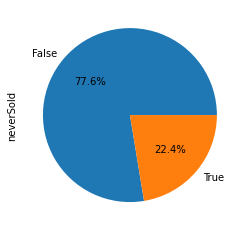

In [42]:
data = pd.DataFrame(bbrsearch)
data['soldYear']=pd.to_datetime(data['soldDate'], errors='coerce').dt.year
data['neverSold'] = (data['soldYear'].isnull())
data['neverSold'].value_counts().plot.pie(autopct="%.1f%%");

#### Save updated `bbrsearch` in file `bbrsearch_noghosts.txt`

In [43]:
with open('bbrsearch_noghosts.txt', 'w') as file:
    file.write(json.dumps(bbrsearch))

### When where they build?

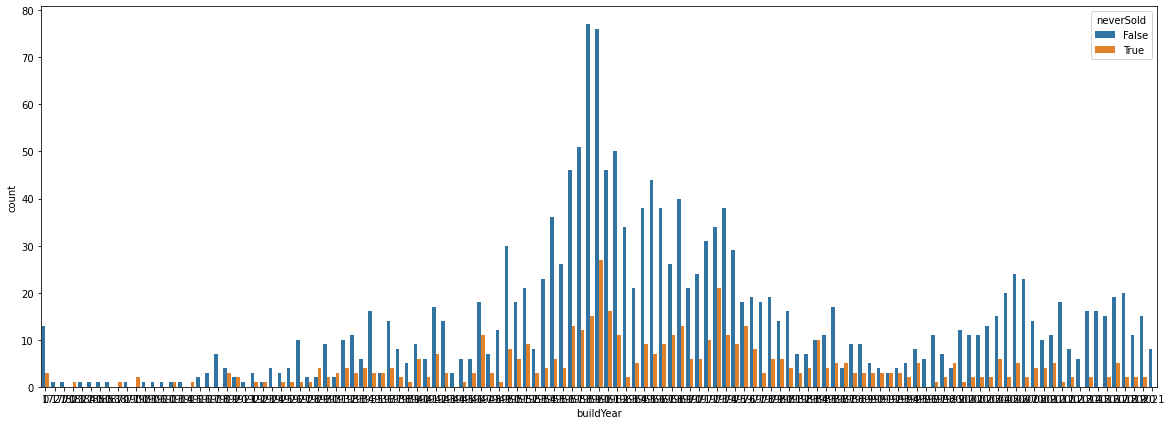

In [44]:
plt.figure(figsize=(20,7));
sns.countplot(data=data,x='buildYear',hue='neverSold');

There's not really a pattern, except that there are some with way too low numbers. This issue with errors in `yearBuild` is something we should be able to fix later with the BBR data, so let's make a note of that.

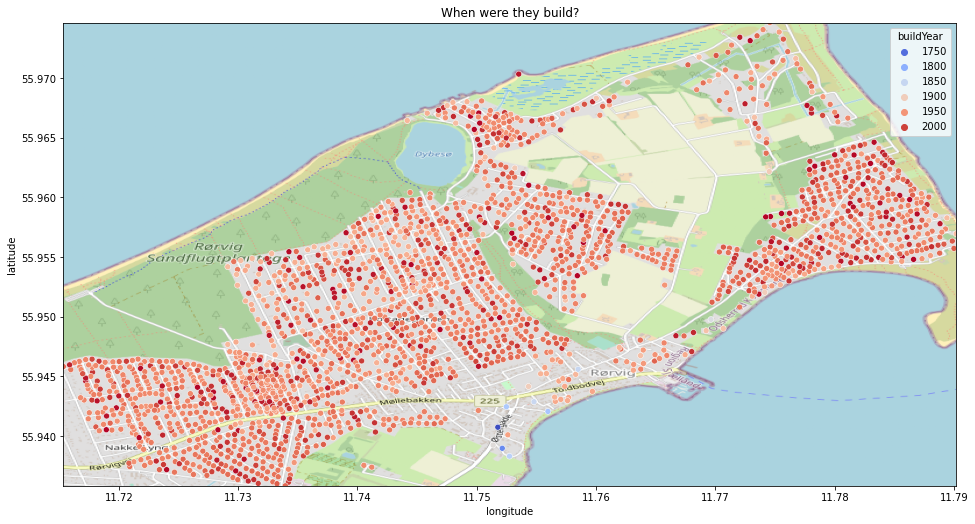

In [45]:
include_map(data.query('buildYear != 0'), hue='buildYear', title='When were they build?',
           palette='coolwarm')

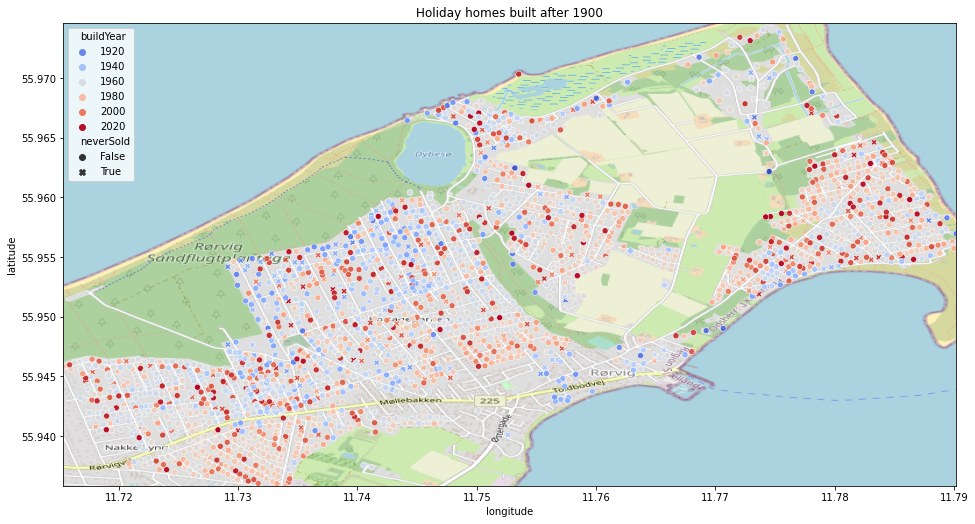

In [46]:
include_map(data.query('buildYear > 1900'), hue='buildYear', title='Holiday homes built after 1900',
           style='neverSold', palette='coolwarm', s=35)

### Size of buildings
We know the size of the buildings too, so let's just see if there's anything there, though I expect it to be a lot less interesting than lot size since we're talking holiday homes. But we don't have the lot size in our data (yet!).

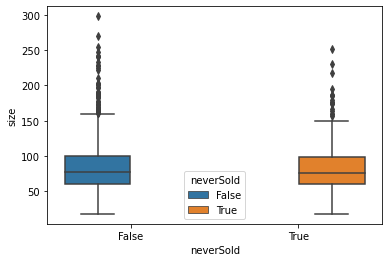

In [47]:
#plt.figure(figsize=(7,7));
sns.boxplot(data=data,x='neverSold', y='size',hue='neverSold');
#plt.figure(figsize=(18,7));
#sns.countplot(data=data,x='size',hue='neverSold');

Some of them look too small. We can hopefully fix is using `unitInfo` from the BBR data `bbrinfo`.

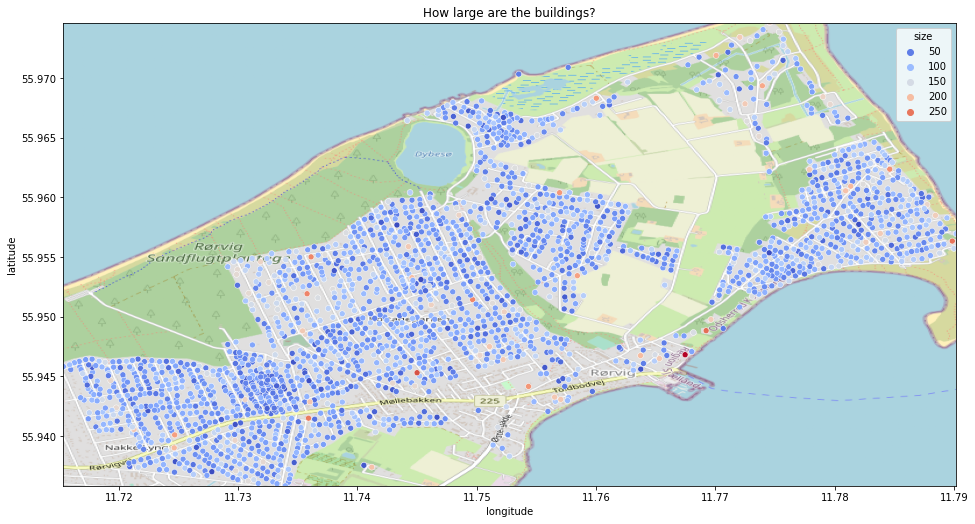

In [48]:
include_map(data, hue='size', title='How large are the buildings?', palette='coolwarm')

### Number of rooms

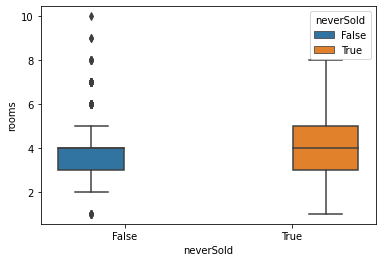

In [49]:
#plt.figure(figsize=(10,7));
sns.boxplot(data=data,x='neverSold', y='rooms',hue='neverSold');
#plt.figure(figsize=(14,7));
#sns.countplot(data=data,x='rooms',hue='neverSold');

The never-sold appear smaller. There's also an issue with some properties having 0 rooms. Make a note of fixing this with the BBR data.